# Проект по SQL

Коронавирус застал мир врасплох, изменив привычный порядок вещей. В свободное время жители городов больше не выходят на улицу, не посещают кафе и торговые центры. Зато стало больше времени для книг. Это заметили стартаперы — и бросились создавать приложения для тех, кто любит читать.

Ваша компания решила быть на волне и купила крупный сервис для чтения книг по подписке. Ваша первая задача как аналитика — проанализировать базу данных.

В ней — информация о книгах, издательствах, авторах, а также пользовательские обзоры книг. Эти данные помогут сформулировать ценностное предложение для нового продукта.

**Описание данных**

Таблица books

Содержит данные о книгах:
- book_id — идентификатор книги;
- author_id — идентификатор автора;
- title — название книги;
- num_pages — количество страниц;
- publication_date — дата публикации книги;
- publisher_id — идентификатор издателя.

Таблица authors

Содержит данные об авторах:
- author_id — идентификатор автора;
- author — имя автора.

Таблица publishers

Содержит данные об издательствах:
- publisher_id — идентификатор издательства;
- publisher — название издательства;

Таблица ratings

Содержит данные о пользовательских оценках книг:
- rating_id — идентификатор оценки;
- book_id — идентификатор книги;
- username — имя пользователя, оставившего оценку;
- rating — оценка книги.

Таблица reviews

Содержит данные о пользовательских обзорах:
- review_id — идентификатор обзора;
- book_id — идентификатор книги;
- username — имя автора обзора;
- text — текст обзора.

**Задания**
- Посчитайте, сколько книг вышло после 1 января 2000 года;
- Для каждой книги посчитайте количество обзоров и среднюю оценку;
- Определите издательство, которое выпустило наибольшее число книг толще 50 страниц — так вы исключите из анализа брошюры;
- Определите автора с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками;
- Посчитайте среднее количество обзоров от пользователей, которые поставили больше 50 оценок.


## Подключимся к базе данных и выведем первые строки таблицы

In [1]:
# импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine
import plotly.express as px
import seaborn as sns
#!pip install psycopg2 

In [2]:
# устанавливаем параметры
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-final-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])
# сохраняем коннектор
engine = create_engine(connection_string, connect_args={'sslmode':'require'}) 

In [3]:
query = '''
           SELECT * 
           FROM books
        '''

In [4]:
books = pd.io.sql.read_sql(query, con = engine) 
print(books.head())

   book_id  author_id                                              title  \
0        1        546                                       'Salem's Lot   
1        2        465                 1 000 Places to See Before You Die   
2        3        407  13 Little Blue Envelopes (Little Blue Envelope...   
3        4         82  1491: New Revelations of the Americas Before C...   
4        5        125                                               1776   

   num_pages publication_date  publisher_id  
0        594       2005-11-01            93  
1        992       2003-05-22           336  
2        322       2010-12-21           135  
3        541       2006-10-10           309  
4        386       2006-07-04           268  


## Напишем SQL запросы 

### Посчитайте, сколько книг вышло после 1 января 2000 года

In [5]:
query = '''
           SELECT COUNT(book_id) 
           FROM books
           WHERE publication_date > '2000-01-01'
        '''
books = pd.io.sql.read_sql(query, con = engine) 
print(books)

   count
0    819


- После **1 января 2000 года** вышло **819** книг.

### Для каждой книги посчитайте количество обзоров и среднюю оценку

In [6]:
query = '''
           WITH
           r AS (SELECT book_id,
                        ROUND(AVG(rating),2) AS rating_avg
                 FROM ratings
                 GROUP BY book_id),
           i AS (SELECT book_id,
                        COUNT(review_id) AS review_cnt
                 FROM reviews
                 GROUP BY book_id),
           b AS (SELECT book_id
                 FROM books)
           
           SELECT r.book_id,
                  r.rating_avg,
                  i.review_cnt
           FROM b LEFT JOIN r ON b.book_id=r.book_id
           LEFT JOIN i ON b.book_id=i.book_id
        '''
books = pd.io.sql.read_sql(query, con = engine) 
print(books)

     book_id  rating_avg  review_cnt
0          1        3.67         2.0
1          2        2.50         1.0
2          3        4.67         3.0
3          4        4.50         2.0
4          5        4.00         4.0
..       ...         ...         ...
995      996        3.67         3.0
996      997        3.40         3.0
997      998        3.20         4.0
998      999        4.50         2.0
999     1000        3.83         4.0

[1000 rows x 3 columns]


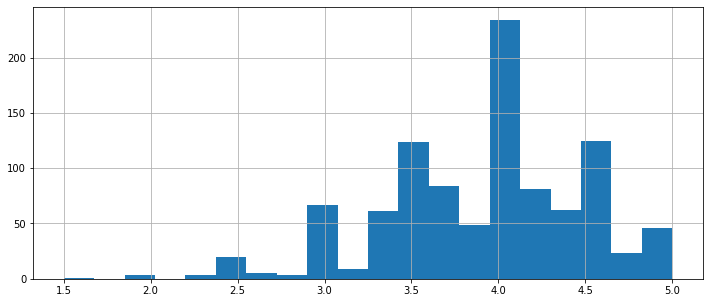

In [7]:
books['rating_avg'].hist(figsize=(12, 5), bins = 20);

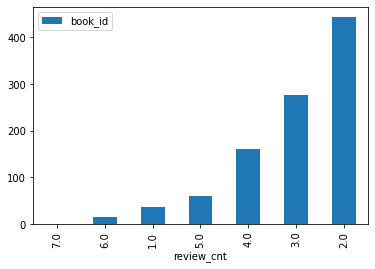

In [9]:
(
    books
        .groupby('review_cnt')
        .agg({'book_id':'count'})
        .sort_values(by='book_id')
        .plot(kind='bar')
);

- Посчитала и визуализировала количество обзоров и среднюю оценку для каждой книги.
- Чаще всего книгам ставят оценку - 4
- Зачастую книги получают 2-3 обзора

### Определите издательство, которое выпустило наибольшее число книг толще 50 страниц

In [10]:
query = '''
           WITH
           p AS (SELECT publisher,
                        publisher_id
           FROM publishers),
           
           b AS (SELECT publisher_id,
                        COUNT(book_id) AS book_cnt
           FROM books
           WHERE num_pages > 50
           GROUP BY publisher_id)
           
           SELECT p.publisher,
                  b.book_cnt
           FROM p JOIN b ON p.publisher_id=b.publisher_id
           ORDER BY b.book_cnt DESC
           LIMIT 1
        '''
books = pd.io.sql.read_sql(query, con = engine) 
print(books)

       publisher  book_cnt
0  Penguin Books        42


- Издательство выпустившее наибольшее кол-во книг толще 50 страниц (так мы исключаем из анализа брошюры) - Penguin Books

### Определите автора с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками

In [11]:
query = '''
           WITH
           r AS (
           SELECT book_id,
                  COUNT(rating_id) AS rat_cnt,
                  AVG(rating) AS rat_avg
           FROM ratings
           GROUP BY book_id),
           
           b AS (
           SELECT book_id,
                  author_id
           FROM books),
           
           a AS (
           SELECT *
           FROM authors)
           
           SELECT a.author,
                  ROUND((AVG(r.rat_avg)),2) AS avg
           FROM b JOIN r ON b.book_id=r.book_id 
           JOIN a ON b.author_id=a.author_id
           WHERE r.rat_cnt >= 50
           GROUP BY a.author
           ORDER BY avg DESC
           --LIMIT 1
        '''
books = pd.io.sql.read_sql(query, con = engine) 
print(books)

                                               author   avg
0                          J.K. Rowling/Mary GrandPré  4.28
1                   Markus Zusak/Cao Xuân Việt Khương  4.26
2                                      J.R.R. Tolkien  4.26
3                                   Louisa May Alcott  4.19
4                                        Rick Riordan  4.08
5                                     William Golding  3.90
6                                       J.D. Salinger  3.83
7   William Shakespeare/Paul Werstine/Barbara A. M...  3.79
8            Paulo Coelho/Alan R. Clarke/Özdemir İnce  3.79
9                                          Lois Lowry  3.75
10                                          Dan Brown  3.75
11            George Orwell/Boris Grabnar/Peter Škerl  3.73
12                                    Stephenie Meyer  3.66
13                                     John Steinbeck  3.62


- Автор с самой высокой средней оценкой книг(Среди книги с 50 и более оценками) - Rowling/Mary GrandPré
- Средняя оценка этого автора - 4.28


### Посчитайте среднее количество обзоров от пользователей, которые поставили больше 50 оценок

In [12]:
query = '''
           WITH
           r AS (
           SELECT DISTINCT(username),
                  COUNT(ratings) OVER (PARTITION BY username) AS rat_cnt
           FROM ratings),
           
           i AS (
           SELECT DISTINCT(username),
                  COUNT(review_id) OVER (PARTITION BY username) AS rev_cnt
           FROM reviews)
           
           SELECT ROUND(AVG(i.rev_cnt),2)
           FROM r JOIN i ON r.username=i.username
           WHERE r.rat_cnt > 50
        '''
books = pd.io.sql.read_sql(query, con = engine) 
print(books)

   round
0  24.33


- Среднее кол-во обзоров от пользователей, которые поставили больше 50 оценок - 24,33
- Оценки люди ставят более охотно, чем пишут обзоры.

## Вывод

- После **1 января 2000 года** вышло **819** книг.
- Чаще всего книгам ставят оценку - 4
- Зачастую книги получают 2-3 обзора
- Издательство выпустившее наибольшее кол-во книг толще 50 страниц (так мы исключаем из анализа брошюры) - Penguin Books
- Автор с самой высокой средней оценкой книг(Среди книги с 50 и более оценками) - Rowling/Mary GrandPré
- Средняя оценка этого автора - 4.28
- Среднее кол-во обзоров от пользователей, которые поставили больше 50 оценок - 24,33
- Оценки люди ставят более охотно, чем пишут обзоры.